In [1]:
import os
import time
import shutil
import traceback
from pathlib import Path

import wandb
import optuna
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
from IPython.display import clear_output
from torchaudio.datasets.speechcommands import SPEECHCOMMANDS, URL, FOLDER_IN_ARCHIVE
from thop import profile

from melbanks import LogMelFilterBanks

/home/akarpova/ITMO/ITMO_GenSpeech/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
DATASET_DIR = Path('data')

In [6]:
LABEL_ENC = {'yes': 1, 'no': 0}

In [9]:
if not DATASET_DIR.exists():
     SPEECHCOMMANDS(DATASET_DIR, download=True)
     DATASET_DIR = DATASET_DIR / FOLDER_IN_ARCHIVE / URL
     for label_dir in Path(DATASET_DIR).glob('*'):
          if label_dir.is_dir() and label_dir.name not in LABEL_ENC.keys():
               shutil.rmtree(label_dir)
else:
      DATASET_DIR = DATASET_DIR / FOLDER_IN_ARCHIVE / URL

In [ ]:
!rm data/speech_commands_v0.02.tar.gz
!sed -i '/no\/\|yes\//!d' data/SpeechCommands/speech_commands_v0.02/testing_list.txt
!sed -i '/no\/\|yes\//!d' data/SpeechCommands/speech_commands_v0.02/validation_list.txt

rm: невозможно удалить 'data/speech_commands_v0.02.tar.gz': Нет такого файла или каталога


In [10]:
train_dataset = SPEECHCOMMANDS('data', subset='training')
val_dataset = SPEECHCOMMANDS('data', subset='validation')
test_dataset = SPEECHCOMMANDS('data', subset='testing')

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
lengths = list(map(lambda x: x[0].shape[1], train_dataset)) + list(map(lambda x: x[0].shape[1], test_dataset)) + list(map(lambda x: x[0].shape[1], val_dataset))

(array([2.000e+00, 0.000e+00, 2.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        1.100e+01, 0.000e+00, 0.000e+00, 1.000e+00, 1.500e+01, 0.000e+00,
        0.000e+00, 1.100e+01, 5.000e+00, 0.000e+00, 1.000e+00, 3.100e+01,
        0.000e+00, 0.000e+00, 1.700e+01, 1.800e+01, 0.000e+00, 0.000e+00,
        2.000e+01, 2.300e+01, 0.000e+00, 2.300e+01, 0.000e+00, 7.900e+01,
        1.500e+01, 2.900e+01, 2.600e+01, 2.000e+00, 4.400e+01, 0.000e+00,
        3.800e+01, 0.000e+00, 4.100e+01, 1.000e+00, 3.600e+01, 5.500e+01,
        0.000e+00, 1.000e+00, 3.900e+01, 5.000e+01, 3.000e+00, 4.300e+01,
        6.200e+01, 7.237e+03]),
 array([ 6144.  ,  6341.12,  6538.24,  6735.36,  6932.48,  7129.6 ,
         7326.72,  7523.84,  7720.96,  7918.08,  8115.2 ,  8312.32,
         8509.44,  8706.56,  8903.68,  9100.8 ,  9297.92,  9495.04,
         9692.16,  9889.28, 10086.4 , 10283.52, 10480.64, 10677.76,
        10874.88, 11072.  , 11269.12, 11466.24, 11663.36, 11860.48,
        12057.6 , 12254.72, 12451.84

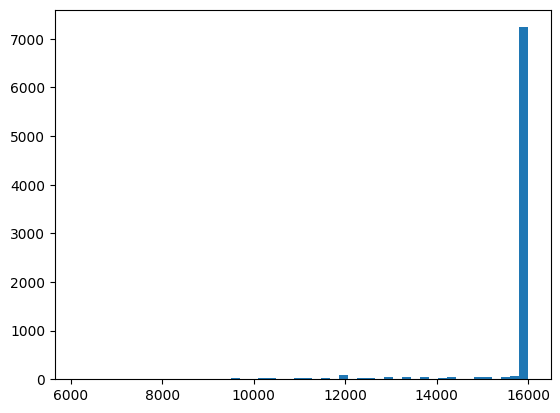

In [9]:
plt.hist(lengths, bins=50)

In [13]:
def collate_fn(batch, pad_to_len=16000, label_enc=LABEL_ENC, device=device):
    padded_waveforms = torch.stack(list(map(lambda x: F.pad(x[0][0], (0, pad_to_len - x[0].shape[1])), batch))).to(device)
    encoded_labels = torch.Tensor(list(map(lambda x: label_enc[x[2]], batch))).to(device)
    return (padded_waveforms, encoded_labels)

In [14]:
class CNN(nn.Module):
    def __init__(self, n_mels, n_groups=1, n_output=2, n_channel=32, device='cpu'):
        super().__init__()
        self.feature_extractor = LogMelFilterBanks(n_mels=n_mels, device=device)
        self.conv1 = nn.Sequential(
            nn.Conv1d(n_mels, n_channel, kernel_size=8, stride=1, groups=n_groups),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2))
        self.conv2 = nn.Sequential(
            nn.Conv1d(n_channel, n_channel * 2, kernel_size=4, stride=1, groups=n_groups),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2),
            )
        self.pool = nn.AdaptiveAvgPool1d(n_channel * 2)
        self.fc1 = nn.Linear(n_channel * 2, n_output)
        self.flatten = nn.Flatten()
        self.fc2 = nn.Linear(n_channel * 4, n_output)
        self.func = nn.Sigmoid()
        self.to(device)
        

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.fc1(x)
        x = self.flatten(x)
        x = self.fc2(x)
        return self.func(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def count_flops(self, x):
        return profile(self, [x])[0]

In [15]:
class ModelTrainer:
    def __init__(self, train_loader, val_loader,
                 metric_name,
                 project_name='itmo-dsp',
                 checkpoint_folder='./models'):
        self.project_name = project_name
        self.checkpoint_folder = checkpoint_folder
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.best_metric = 0.0
        self.val_dataset_size = len(self.val_loader.dataset)
        self.train_dataset_size = len(self.train_loader.dataset)
        self.metric_name = metric_name

    def validate(self, model):
        model.eval()
        accuracy = 0

        with torch.no_grad():
            for inputs, labels in self.val_loader:
                outputs = model(inputs)
                preds = torch.argmax(outputs, 1)
                accuracy += (preds == labels).sum()

        accuracy = float(accuracy / self.val_dataset_size)

        metrics = {
            'val_acc': accuracy,
        }
        return metrics

    def save_model_locally(self, model):
        torch.save(model.state_dict(), self.best_model_path)

    def track_progress(self, metrics, patience, trial, epoch, epochs_without_improvement):
        if metrics[self.metric_name] > self.best_metric:
            epochs_without_improvement = 0
            self.best_metric = metrics[self.metric_name]
            if self.best_model_path:
                os.remove(self.best_model_path)
            self.best_model_path = Path(self.checkpoint_folder) / f'{self.name}_{self.metric_name}{self.best_metric:.4f}.pth'
        else:
            if epochs_without_improvement > patience:
                print('Early stopping')
                raise optuna.TrialPruned()
            epochs_without_improvement += 1
        if trial:
            trial.report(metrics[self.metric_name], epoch)
            if trial.should_prune():
                print('[OPTUNA] Run pruned')
                raise optuna.TrialPruned()
        return epochs_without_improvement

    def log_metrics(self, run, metrics, epoch, progress_bar, n_epochs):
        clear_output()
        progress_bar.set_postfix(metrics)
        run.log(metrics)

    def train_epoch(self, model, optimizer, loss_fn, device):
        model.train()
        loss = 0
        t0 = time.time()
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs[:, 1], labels)
            loss.backward()
            optimizer.step()

            loss += loss.item()

        loss /= self.train_dataset_size

        metrics = {
            'epoch_training_time': time.time() - t0,
            'train_loss': float(loss),
            'parameter_count': model.count_parameters(),
            'flops': model.count_flops(next(iter(self.val_loader))[0])
        }

        return model, metrics

    def train(self, model, loss_fn, optim_class, optim_args, device,
              n_epochs=100, patience=100, run_name=None, run_config=None, trial=None):
        run = wandb.init(project=self.project_name, name=run_name, config=run_config)
        self.name = run_name
        optimizer = optim_class(model.parameters(), **optim_args)
        model = model.to(device)
        self.best_model_path = None
        self.best_metric = 0
        progress_bar = tqdm(range(n_epochs), desc='Training', leave=True)
        epochs_without_improvement = 0
        os.makedirs(self.checkpoint_folder, exist_ok=True)
        try:
            for epoch in progress_bar:
                model, train_metrics = self.train_epoch(model, optimizer, loss_fn, device)
                val_metrics = self.validate(model)
                metrics = {**train_metrics, **val_metrics, 'epoch': epoch}
                epochs_without_improvement = self.track_progress(metrics, patience, trial, epoch, epochs_without_improvement)
                if epochs_without_improvement == 0:
                    self.save_model_locally(model)
                self.log_metrics(run, metrics, epoch, progress_bar, n_epochs)
                plt.show()
        except (Exception, KeyboardInterrupt) as e:
            print(traceback.format_exc())
        finally:
            progress_bar.close()
            wandb.finish()
        return model

    def optimize(self, objective, model_class, loss_fn, n_trials=20, n_epochs=100, 
                   device='cuda' if torch.cuda.is_available() else 'cpu',
                   direction='maximize'):
        """Run Optuna optimization for learning rate"""
        study = optuna.create_study(
            direction='minimize',
            # pruner=optuna.pruners.MedianPruner(),
        )
        
        try:
            study.optimize(
                lambda trial: objective(
                    self,
                    trial, 
                    model_class, 
                    loss_fn, 
                    device, 
                    n_epochs
                ),
                n_trials=n_trials,
                show_progress_bar=True
            )
            
            print("\nOptimization Results:")
            print('Best params:', study.best_params)
            print('Best metric:', study.best_value)
            
            return study
            
        except Exception as e:
            print(f"Optimization failed: {str(e)}")
            return None, None



In [16]:
def objective(trainer, trial, model_class, loss_fn, device, n_epochs=100):
    optimizer_class = optim.Adam
    lr = trial.suggest_float('lr', low=1e-5, high=1e-1, log=True)
    n_mels = trial.suggest_categorical('n_mels', [20, 40, 80])
    model = model_class(n_mels=n_mels)
    run_config = {
        'n_mels': n_mels,
        'lr': lr,
        }
    run_name = f'CNN_Adamlr_{lr:.3e}_mels{n_mels}'
    trainer.train(
        model=model,
        loss_fn=loss_fn,
        optim_class=optimizer_class,
        optim_args={'lr': lr},
        device=device,
        n_epochs=n_epochs,
        trial=trial,
        run_config=run_config,
        run_name=run_name
    )
    return trainer.best_metric

In [17]:
train_loader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=512)
test_loader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=512)

In [18]:
trainer = ModelTrainer(train_loader, test_loader, metric_name='val_acc')
loss_fn = torch.nn.BCELoss()

In [ ]:
trained_model = trainer.optimize(
    model_class=CNN,
    loss_fn=nn.BCELoss(),
    objective=objective,
    n_epochs=100,
    n_trials=100
)

In [ ]:
for n_mels in [20, 40, 60, 80]:
    model = CNN(n_mels=n_mels).to(device)
    model.train()
    trainer.train(model, loss_fn, optim.Adam, optim_args={'lr': 1e-4}, device=device,
                  run_name=f'Adamlr1e-4_nmels{n_mels}', run_config={'n_mels': n_mels, 'lr': 1e-4})

In [21]:
test_batch = next(iter(test_loader))[0]

In [ ]:
n_groups_dict = {}
for n_groups in [1, 2, 4, 8, 16]:
    model = CNN(n_mels=80, n_groups=n_groups, device=device)
    model.train()
    model = trainer.train(model, loss_fn, optim.Adam, optim_args={'lr': 1e-4}, device=device,
                  run_name=f'Adamlr1e-4_nmels80_ngroups{n_groups}', run_config={'n_mels': 80, 'lr': 1e-4, 'n_groups': n_groups})
    n_groups_dict[n_groups] = {'model_params': model.count_parameters(), 'flops': model.count_flops(test_batch)}

In [21]:
n_groups = 8
model = CNN(n_mels=80, n_groups=n_groups, device=device)
model.train()
model = trainer.train(model, loss_fn, optim.Adam, optim_args={'lr': 1e-4}, device=device,
                run_name=f'Adamlr1e-4_nmels80_ngroups{n_groups}', run_config={'n_mels': 80, 'lr': 1e-4, 'n_groups': n_groups})
# n_groups_dict[n_groups] = {'model_params': model.count_parameters(), 'flops': model.count_flops(test_batch)}

Training: 100%|██████████| 100/100 [20:32<00:00, 12.32s/it, epoch_training_time=9.79, train_loss=5.11e-5, parameter_count=4068, flops=1.53e+8, val_acc=0.751, epoch=99]


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
epoch_training_time,▆▅▅▃▃▅▄▃▃▃▂▄▃▄▅▄▄▅▅▆▅▅▅▅▃▃▄▄▂▃▂▄██▁▄▃▂▂▁
flops,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
parameter_count,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,███▇▇▇▆▅▅▄▃▄▃▄▃▁▃▃▂▂▃▃▃▂▃▂▂▃▁▂▁▂▁▂▂▁▂▁▁▁
val_acc,▁▂▂▂▂▃▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇████████████▇▇▇▇▇▇▇
epoch,99
epoch_training_time,9.79025
flops,153419776.0
parameter_count,4068
train_loss,5e-05


In [19]:
n_groups = 16
model = CNN(n_mels=80, n_groups=n_groups, device=device)
model.train()
model = trainer.train(model, loss_fn, optim.Adam, optim_args={'lr': 1e-4}, device=device,
                run_name=f'Adamlr1e-4_nmels80_ngroups{n_groups}', run_config={'n_mels': 80, 'lr': 1e-4, 'n_groups': n_groups})
# n_groups_dict[n_groups] = {'model_params': model.count_parameters(), 'flops': model.count_flops(test_batch)}

Training: 100%|██████████| 100/100 [19:58<00:00, 11.98s/it, epoch_training_time=9.73, train_loss=5.59e-5, parameter_count=2276, flops=8.03e+7, val_acc=0.585, epoch=99]


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇███
epoch_training_time,▆▂▁▂▂▂▁▁▂▄▆▂▄▂▂▁▂▂▂▂██▇▆▅▆▅▇▄▅▂▄▅▃▃▁▂▁▂▂
flops,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
parameter_count,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,██▇▆▆▅▅▅▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▂▂▁▁▂
val_acc,█▆▄▄▃▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
epoch,99
epoch_training_time,9.72717
flops,80281600.0
parameter_count,2276
train_loss,6e-05


In [13]:
import pandas as pd
import plotly.express as px

In [14]:
data = []
n_groups = [1, 2, 4, 8, 16]
for n in n_groups:
    for device in ['cpu', 'cuda:0']:
        model = CNN(n_mels=80, n_groups=n, device=device)
        for batch_sz_log2 in tqdm(range(10)):
            batch_sz = 2 ** batch_sz_log2
            t0 = time.time()
            flops = model.count_flops(next(iter(test_loader))[0][:batch_sz].to(device))
            t_batch = time.time() - t0
            data.append([n, batch_sz, flops, model.count_parameters(), t_batch, device])
        clear_output()

In [32]:
data

[[1, 1, 2299520.0, 29156, 0.7756717205047607, 'cpu'],
 [1, 2, 4599040.0, 29156, 0.7494165897369385, 'cpu'],
 [1, 4, 9198080.0, 29156, 0.7610418796539307, 'cpu'],
 [1, 8, 18396160.0, 29156, 0.7635612487792969, 'cpu'],
 [1, 16, 36792320.0, 29156, 0.7921202182769775, 'cpu'],
 [1, 32, 73584640.0, 29156, 0.784250020980835, 'cpu'],
 [1, 64, 147169280.0, 29156, 0.7781903743743896, 'cpu'],
 [1, 128, 294338560.0, 29156, 0.7801623344421387, 'cpu'],
 [1, 256, 588677120.0, 29156, 0.780219316482544, 'cpu'],
 [1, 512, 1177354240.0, 29156, 0.8400776386260986, 'cpu'],
 [1, 1, 2299520.0, 29156, 0.7696993350982666, 'cuda:0'],
 [1, 2, 4599040.0, 29156, 0.7774419784545898, 'cuda:0'],
 [1, 4, 9198080.0, 29156, 0.7793612480163574, 'cuda:0'],
 [1, 8, 18396160.0, 29156, 0.7623589038848877, 'cuda:0'],
 [1, 16, 36792320.0, 29156, 0.7644367218017578, 'cuda:0'],
 [1, 32, 73584640.0, 29156, 0.7588129043579102, 'cuda:0'],
 [1, 64, 147169280.0, 29156, 0.7611575126647949, 'cuda:0'],
 [1, 128, 294338560.0, 29156, 0.76

In [42]:
df = pd.DataFrame(data, columns=['n_groups', 'batch size', 'FLOPS', 'model params count', 'batch inference time', 'device'])
df

,n_groups,batch size,FLOPS,model params count,batch inference time,device
0,1,1,2299520.0,29156,0.775672,cpu
1,1,2,4599040.0,29156,0.749417,cpu
2,1,4,9198080.0,29156,0.761042,cpu
3,1,8,18396160.0,29156,0.763561,cpu
4,1,16,36792320.0,29156,0.792120,cpu
...,...,...,...,...,...,...
95,16,32,5017600.0,2276,0.754998,cuda:0
96,16,64,10035200.0,2276,0.770443,cuda:0
97,16,128,20070400.0,2276,0.752413,cuda:0
98,16,256,40140800.0,2276,0.758720,cuda:0


In [16]:
df = pd.DataFrame(data, columns=['n_groups', 'batch size', 'FLOPS', 'model params count', 'batch inference time', 'device'])
df

,n_groups,batch size,FLOPS,model params count,batch inference time,device
0,1,1,2299520.0,29156,0.927199,cpu
1,1,2,4599040.0,29156,0.819839,cpu
2,1,4,9198080.0,29156,0.785863,cpu
3,1,8,18396160.0,29156,0.805671,cpu
4,1,16,36792320.0,29156,0.789685,cpu
...,...,...,...,...,...,...
95,16,32,5017600.0,2276,0.777854,cuda:0
96,16,64,10035200.0,2276,0.767040,cuda:0
97,16,128,20070400.0,2276,0.769361,cuda:0
98,16,256,40140800.0,2276,0.767772,cuda:0


In [40]:
px.line(df, x='n_groups', y='FLOPS', color='batch size', facet_col='device', line_shape='spline')

In [56]:
df

,n_groups,batch size,FLOPS,model params count,batch inference time,device
0,1,1,2299520.0,29156,0.816918,cpu
1,1,2,4599040.0,29156,0.774386,cpu
2,1,4,9198080.0,29156,0.787228,cpu
3,1,8,18396160.0,29156,0.829974,cpu
4,1,16,36792320.0,29156,0.796389,cpu
...,...,...,...,...,...,...
95,16,32,5017600.0,2276,0.777234,cuda:0
96,16,64,10035200.0,2276,0.761743,cuda:0
97,16,128,20070400.0,2276,0.765219,cuda:0
98,16,256,40140800.0,2276,0.760201,cuda:0


In [51]:
px.line(df, x='n_groups', y='batch inference time', color='batch size', facet_col='device')

In [19]:
px.line(df, x='n_groups', y='model params count', line_shape='spline')